In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

from time import sleep
import os
import seaborn as sns
from IPython.display import display

%matplotlib inline 

In [3]:
%load_ext autoreload
%autoreload 2

from functions.helper_functions import (StanModel_cache, 
                                        vb, model_dict)

run_in_parallel = False

<h3>Run the following cell, if you want to run different models in parallel, otherwise skip the cell.</h3>
<p>Before running the cell, start clusters. E.g. run 'ipcluster start -n 4'.</p>
<p>More information on: https://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started </p>

In [4]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc.load_balanced_view()

with rc[:].sync_imports():
    import numpy as np
    import pandas as pd
    import pystan
    
    from functions.helper_functions import (vb, model_dict)
print(rc.ids)

run_in_parallel = True

importing numpy on engine(s)
importing pandas on engine(s)
importing pystan on engine(s)
importing vb,model_dict from functions.helper_functions on engine(s)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


<h1>Load Data</h1>

In [5]:
N = 60  # max: 120

data = pd.read_csv('example_data/stock_data_17_18.csv', index_col='Date', parse_dates=['Date']).iloc[:,:N]
stock_list = data.columns

print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )
display(data.head())



# visualize data
if N <= 30:
    fig = plt.figure(figsize=(20,10))

    ax = fig.add_subplot(121)
    np.cumprod(1+data, axis=0).plot(ax=ax, title='stock price')
    np.cumprod(1+data.mean(axis=1)).plot(ax=ax, label='mean', color='black')
    ax.legend()

    ax = fig.add_subplot(122)
    data.plot(ax=ax, title='returns')

    plt.show()

number of nan's: 0
shape data: (250, 60)


,SNPS,HOG,TGT,JBHT,C,GPN,DOV,ITW,CL,PLD,...,PPG,DLPH,CME,CBOE,PNC,SYY,CINF,FCX,DXC,CBS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.003369,0.011028,0.014571,0.010850,0.013533,0.037305,0.004711,0.003836,0.010986,0.017803,...,0.021207,0.037015,0.009790,0.039310,0.008477,0.009146,0.003694,0.076197,0.038045,0.020966
2017-01-05,0.003693,0.001007,-0.016935,-0.006440,-0.017424,0.003966,-0.003256,-0.011220,0.008904,0.000372,...,-0.016963,-0.006140,0.003463,-0.010411,-0.013365,-0.003263,-0.004075,-0.014160,-0.002522,-0.003955
2017-01-06,0.003512,-0.009221,-0.015435,0.005144,0.003480,0.014029,0.015550,0.010443,0.007629,0.006510,...,-0.000314,-0.006321,0.010956,0.005460,0.014227,0.007092,0.000264,0.019152,0.010113,-0.018174
2017-01-09,0.001333,-0.016074,-0.000140,-0.008394,-0.005450,0.071726,-0.012867,-0.004883,-0.013955,-0.007577,...,0.007951,-0.016047,-0.007339,-0.012848,-0.007140,0.005417,-0.016891,-0.014765,-0.002002,-0.012599
2017-01-10,0.010153,0.006019,0.000000,0.008775,0.000166,-0.023938,0.003910,0.002372,-0.015507,-0.022905,...,0.000415,0.035410,-0.000258,-0.011405,0.003976,-0.006286,0.000268,0.059264,0.012372,-0.012445


<h1>Compile Stan Code</h1>

In [6]:
file = "functions/stan_gplvm_finance.stan"
with open(file) as f:
    stan_code = f.read()

stan_model = StanModel_cache(model_code=stan_code)

Using cached StanModel


<h1>Train Model</h1>

In [7]:
def run_calc(model_name, Q, num):
    #shared variables: N, D, Y, model_dict, stan_model, tries
    import pandas as pd
    import numpy as np
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y, 'model_number':model_dict[model_name]}
    n_error, should_break, n_error_max = 0, False, 5
    while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                  # if more then 5 times: break.
        try:
            diagnostic, sample = vb(data_dict, stan_model, tries=tries, num=num)
            n_error = n_error_max
        except RuntimeError:
            n_error += 1
            if n_error == n_error_max: should_break = True
            print('RuntimeError')
    #diagnostic, sample = vb(data_dict, stan_model, tries=tries, num=num)

    if should_break:
        print('RuntimeError occurred too often.')
        return None
    elbo = diagnostic.loc[:, 'ELBO'].values[-1]
    r2 = sample.filter(regex='^R2_hat_N$').mean(axis=0).values.squeeze()
    lengthscale = sample.filter(regex='^kernel_lengthscale$')\
        .mean(axis=0).values.squeeze()
    lengthscale_median = sample.filter(regex='^kernel_lengthscale$')\
        .median(axis=0).values.squeeze()
    diag_std = sample.filter(regex='^diag_std').mean(axis=0).values.squeeze()
    noise_std = sample.filter(regex='^noise_std').mean(axis=0).values.squeeze()
    signal_to_noise = sample.filter(regex='^R2$').mean(axis=0).values.squeeze()
    frequency = sample.filter(regex='^frequency$').mean(axis=0).values.squeeze()
    alpha = sample.filter(regex='^alpha$').mean(axis=0).values.squeeze()
    
    # -- uncomment the following lines if you want to get the cov-matrix and X 
    # -- adjust return of this funtion accordingly
    
    #cov = sample.filter(regex='^K').mean(axis=0).values.reshape(N,-1)
    #X = sample.filter(regex='^X.\d{1,4}.\d{1,3}$') \
    #            .mean(axis=0).values.reshape(Q, N).T
    
    col_names = ['model_name', 'Q', 'ELBO', 'R2', 
                 'lengthscale', 'alpha' ]
    df = pd.DataFrame({num: (model_name, Q, elbo, r2, 
                             lengthscale, alpha)}, 
                      index=col_names).T
    return df   #, cov, X

<h2>Specify parameter</h2>
<p>to get a better convergence, increase 'tries'. Note that $Y \in \mathbb{R}^{N \times D}$ is data.T</p>

In [8]:
Y = data.T.values    # NxD input matrix to GPLVM 
N, D = Y.shape 
tries = 15            # number of runs for each Q and kernel. 
                     # run with the highest ELBO is kept

# specify kernels and Qs to run
model_names = ['linear', 'squared_exp', 'exp', 'matern32']#, 'matern52']
Qs = [1,2,3,4,5,6,7]

## possible models: 'linear', 'squared_exp', 'exp', 'matern32', 'matern52', 
##                'squared_exp_m_linear', 'exp_m_linear', 'squared_exp_p_linear', 'exp_p_linear'


inp = [(model_name, Q) for model_name in model_names for Q in Qs]

# randint used to name temporary files, avoids conflicts between different runs
randint = np.random.randint(0, 1e+10)       
inp = [[*el, i+randint] for i, el in enumerate(inp)]
print('number inputs: {}'.format(len(inp)))

number inputs: 28


<hr>
<h4>If ipyparallel is imported the runs are distributed among all CPUs
otherwise inp-list is processed sequentially</h4>
<p>Note: if the list of inputs is too long and you not running ipyparallel, it might take a lot of time</p>

In [9]:
%%time
if run_in_parallel:
    async_res = []
    ids = []

    rc[:].push(dict(N=N, D=D, Y=Y, stan_model=stan_model, tries=tries), block=True)

    for param in inp:
        re = dview.apply_async(run_calc, *param)
        async_res.append(re)
        ids.extend(re.msg_ids)

    # display progress
    sleep(10)
    while True:
        print(str(len(rc.result_status(ids)['pending'])) +"/"
              +str(len(rc.result_status(ids)['pending'])
                   +len(rc.result_status(ids)['completed']))
              +" still running. on " + str(len(rc.ids)) + " cores", end="\r")
        sleep(10)
        if len(rc.result_status(ids)['pending']) == 0: break
    
    
    # collect results 
    results = [r.get() for r in async_res]
    
    
else:
    # to get rid of the stan-warnings comment out the warning lines (second and 
    # third last line) in the pystan source code (file: pystan/model.py - vb() )
    # if you use a pickled model - recompile it after commenting out the lines
    
    results = []
    print('starting calculations ...', flush=True)
    for i, inp_ in enumerate(inp):
        results.append( run_calc(*inp_) )
        print('{}% done'.format( int(100*(i+1)/len(inp)) ), end='\r', flush=True)


if len(results[0]) == 1:  # only if run_calc() just returns a dataframe (no cov or X)
    results = pd.concat(results)

CPU times: user 5.99 s, sys: 1.4 s, total: 7.4 s
Wall time: 1h 23min 56s


<h4>Display Results</h4>
<p>following cell only runs if run_calc() just returns a dataframe</p>

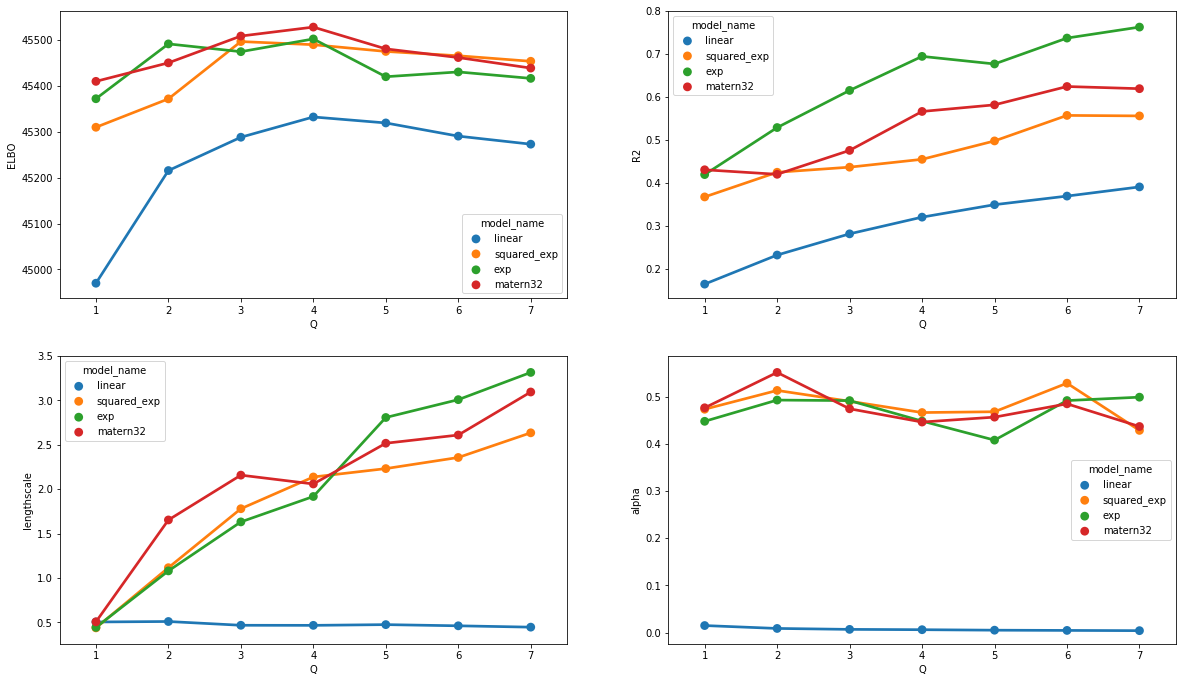

In [10]:
fig = plt.figure(figsize=(20,18))
for i,l in enumerate(['ELBO', 'R2', 'lengthscale', 'alpha']):
    ax = fig.add_subplot(3,2,i+1)
    sns.pointplot(x='Q', y=l, hue='model_name', data=results, ax=ax)
plt.show()